# CONVEX HULL

In [20]:
import json
import re

complist = [1,2,3,4]
with open('ENTHALPY/EntGS.json') as f:
    ent_gs_dict = json.load(f)
with open('ENTHALPY/OneEl.json') as f:
    one_el = json.load(f)

hull_dict = {}
hull_dict_gs = {}
for comp in complist:
    with open(f'ENTHALPY/A{comp}B.json') as f:
        data = json.load(f)

    for pair in data.keys():
        A = re.search(r'([A-Z][a-z]*)([A-Z][a-z]*)', pair).group(1)
        B = re.search(r'([A-Z][a-z]*)([A-Z][a-z]*)', pair).group(2)
        
        entA = one_el[A]
        entB = one_el[B]

        ent_min = min(data[pair].values()) - (entA*comp + entB)/(comp+1)
        ent_gs = ent_gs_dict[f'{comp}'][pair] - (entA*comp + entB)/(comp+1)

        if f'{B}{A}' in hull_dict.keys():
            hull_dict[f'{B}{A}'].append(ent_min)
            hull_dict_gs[f'{B}{A}'].append(ent_gs)
        elif f'{A}{B}' in hull_dict.keys():
            hull_dict[f'{A}{B}'].insert(0,ent_min)
            hull_dict_gs[f'{A}{B}'].insert(0,ent_gs)
        else:
            hull_dict[f'{A}{B}'] = [ent_min]
            hull_dict_gs[f'{A}{B}'] = [ent_gs]
        

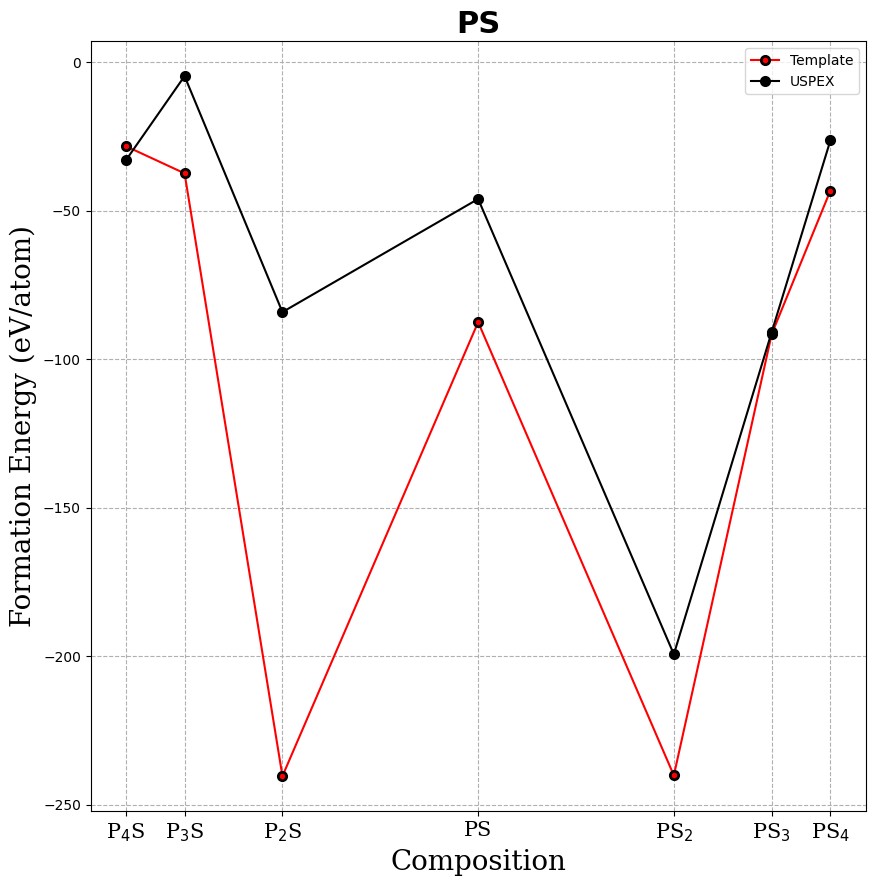

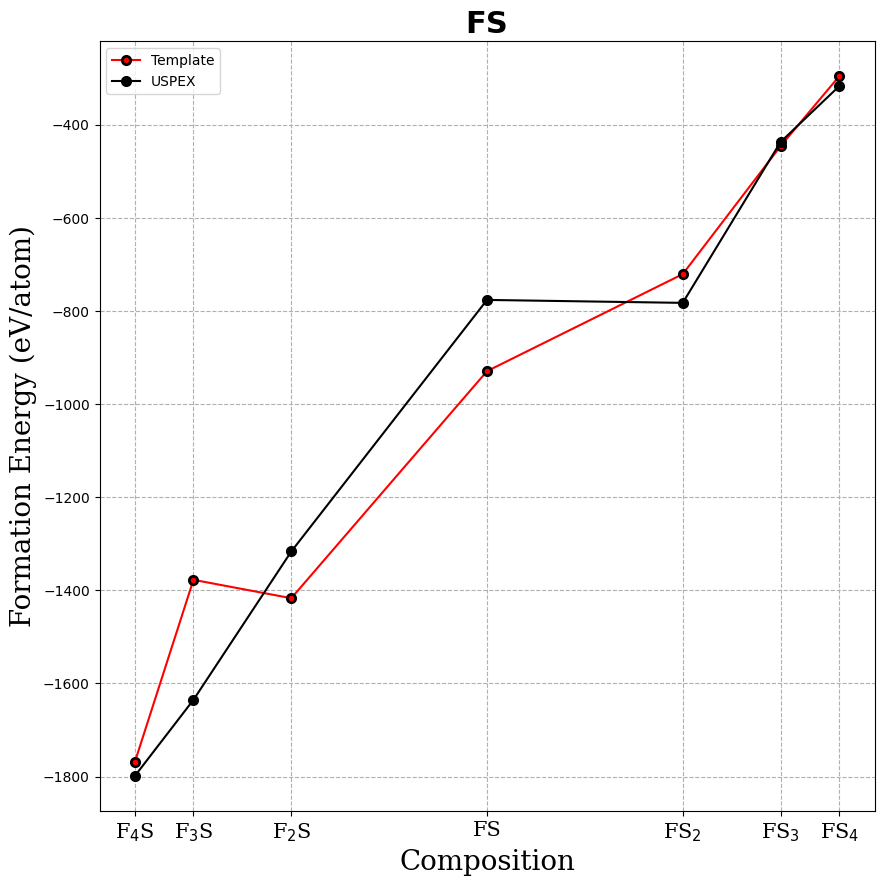

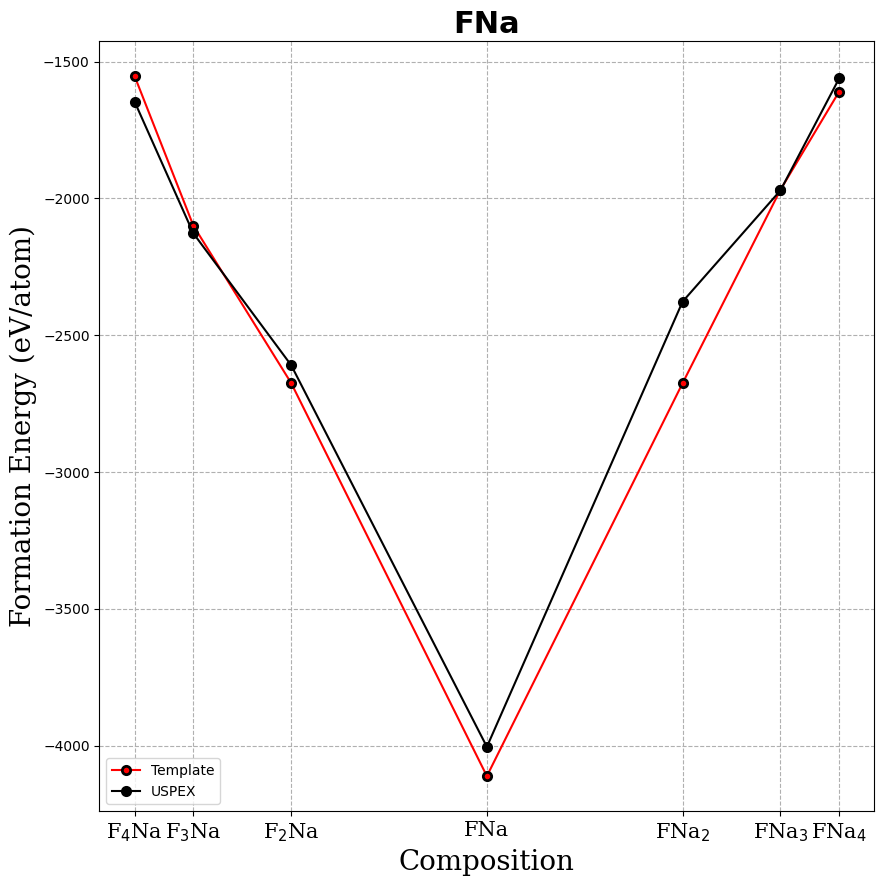

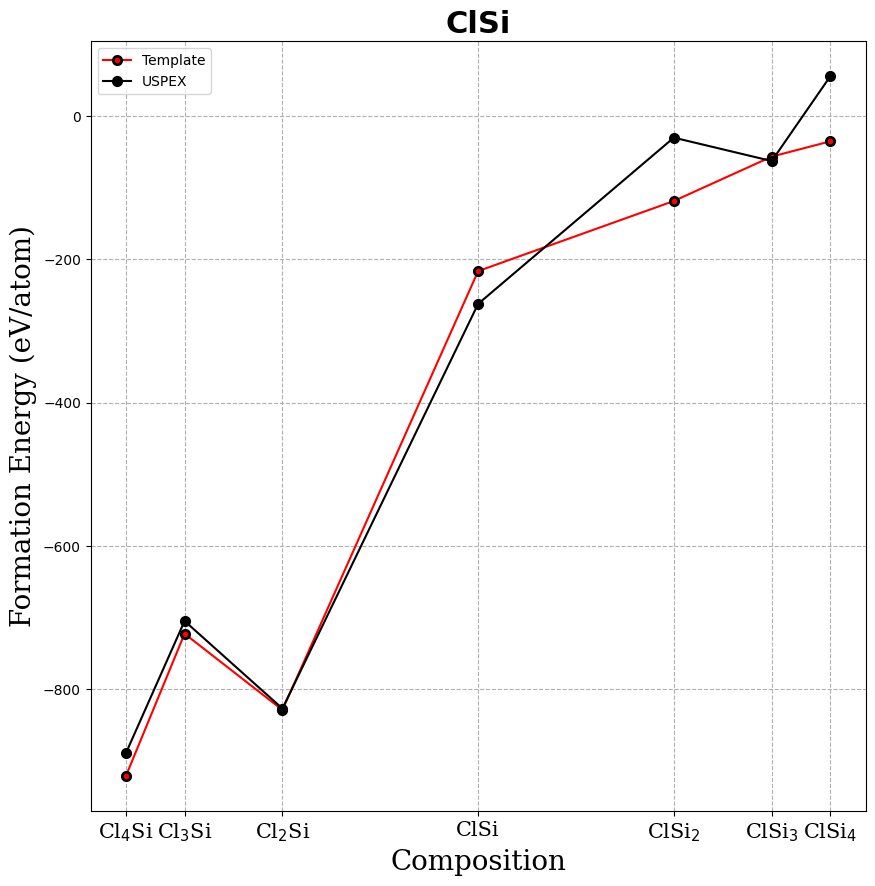

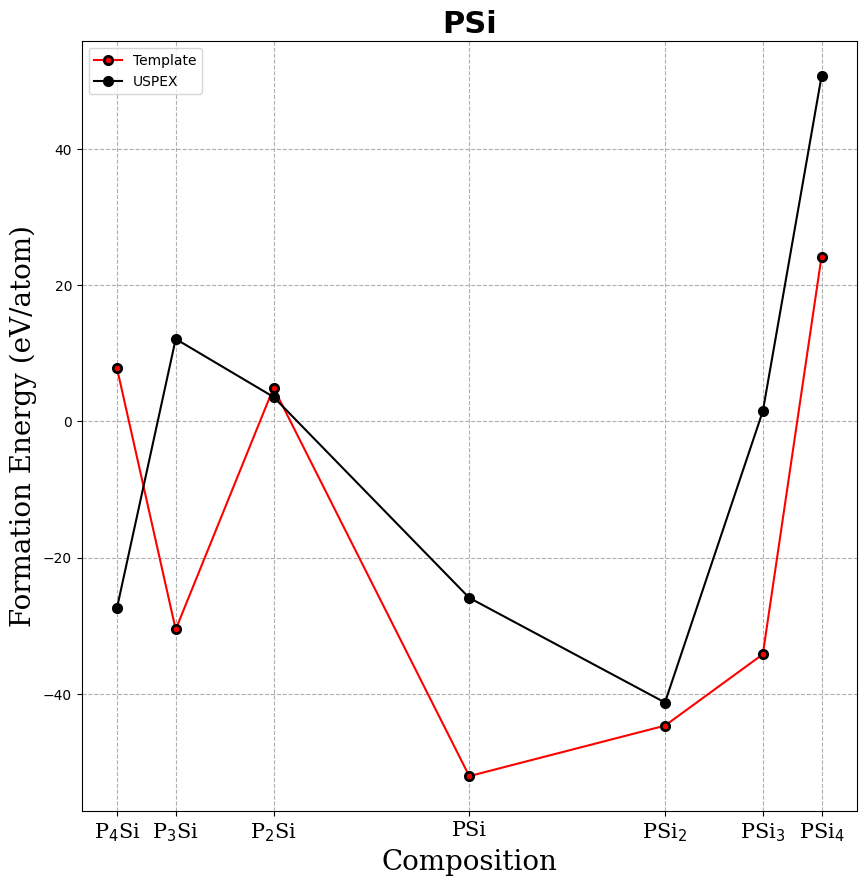

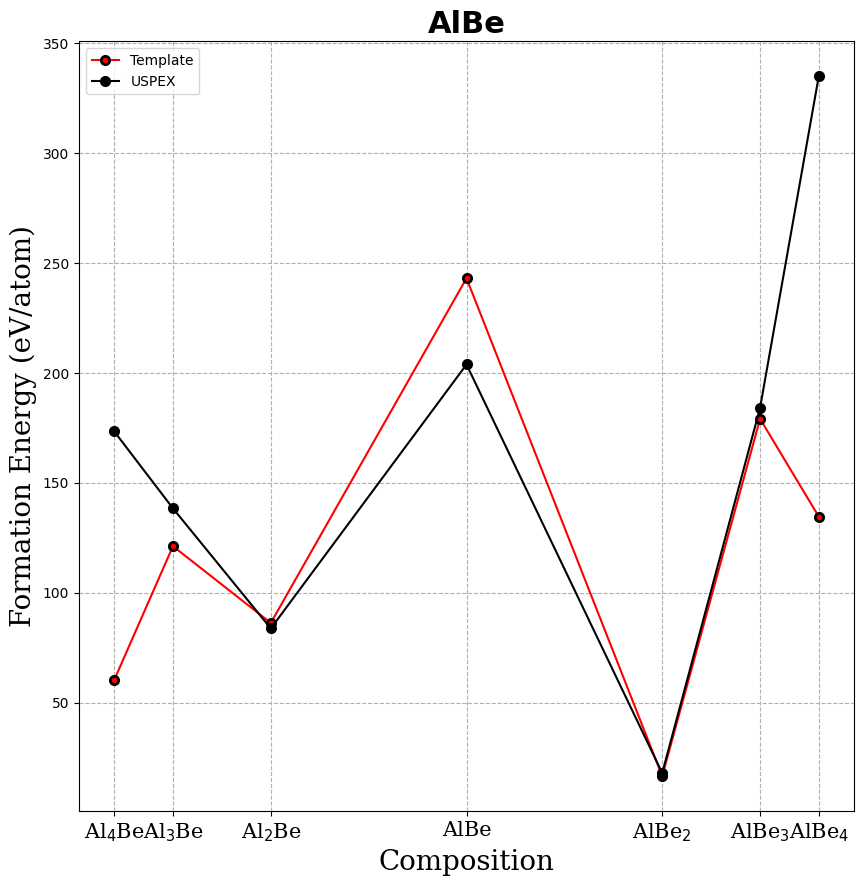

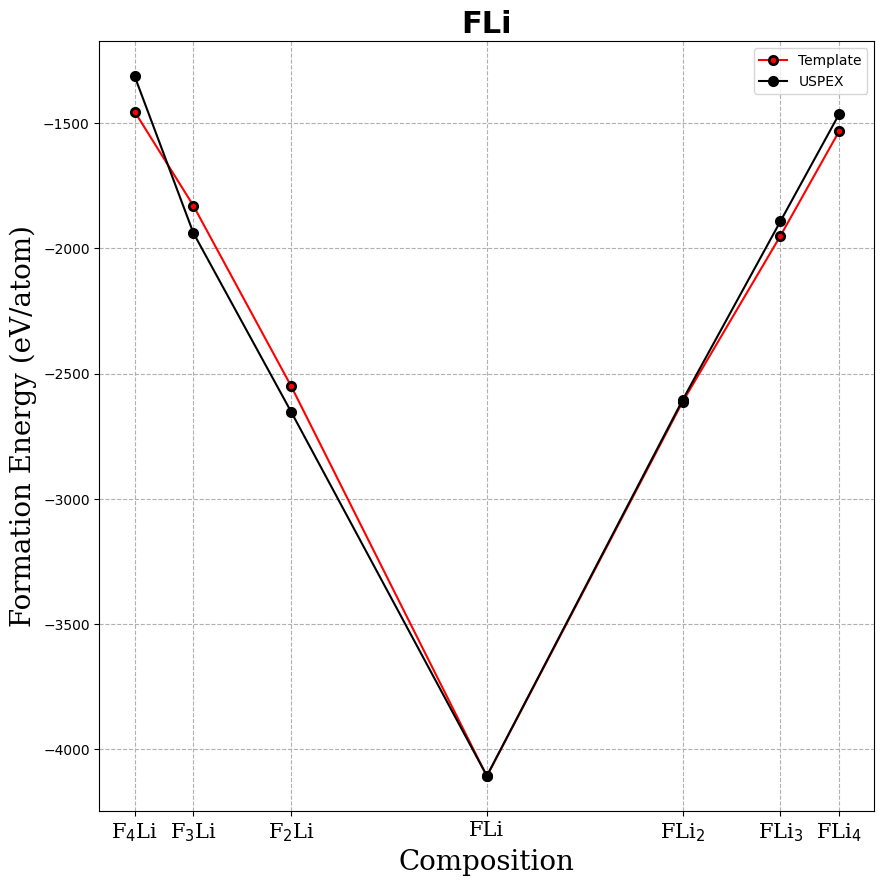

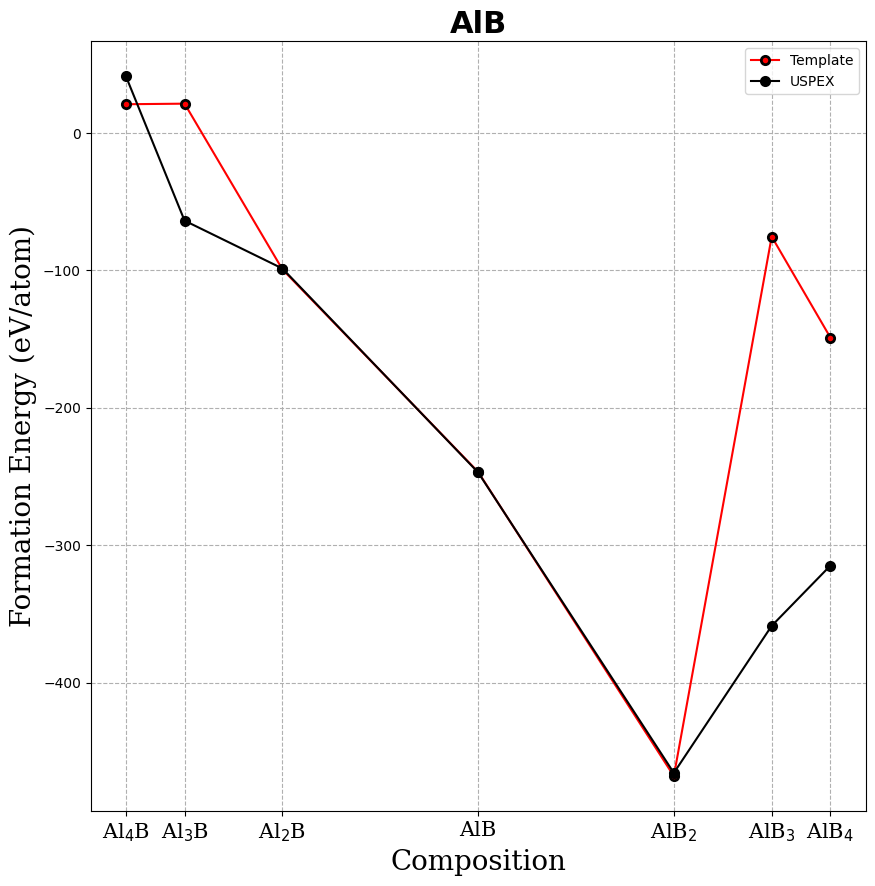

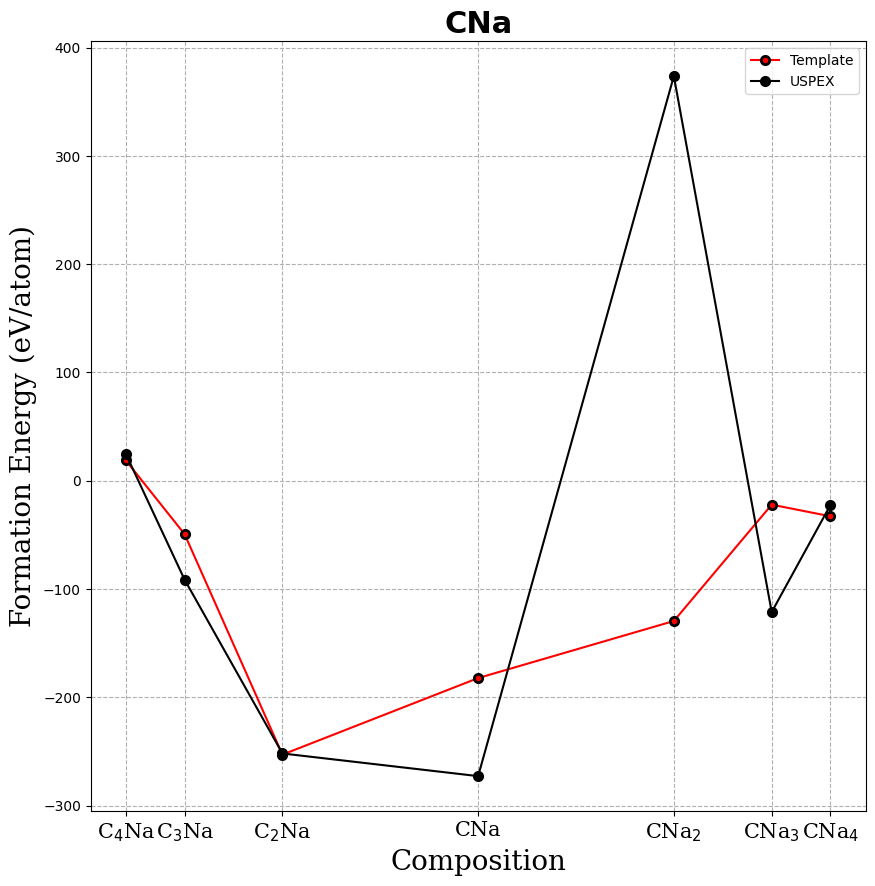

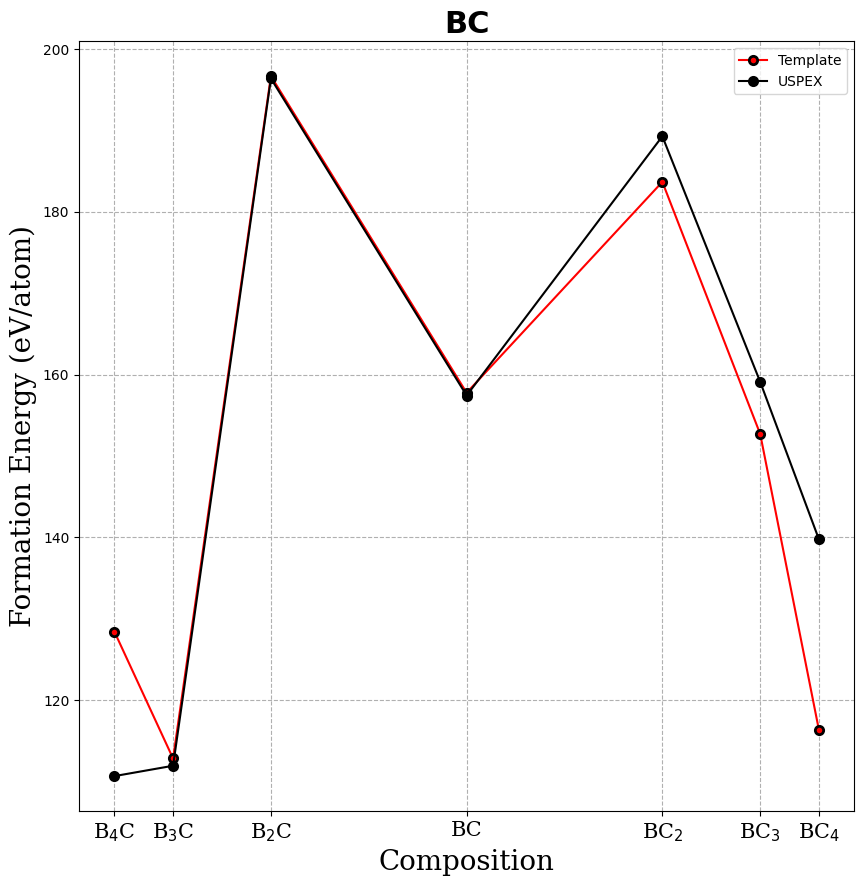

In [27]:
import matplotlib.pyplot as plt
import re
x = [1/5,1/4,1/3,1/2,2/3,3/4,4/5]
lista_pair = list(hull_dict.keys())

for i in range(10):
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    ax.set_title(f'{lista_pair[i]}', fontsize=22, fontweight='bold')
    A = re.search(r'([A-Z][a-z]*)([A-Z][a-z]*)', lista_pair[i]).group(1)
    B = re.search(r'([A-Z][a-z]*)([A-Z][a-z]*)', lista_pair[i]).group(2)
    
    ax.plot(x, [j*1000 for j in hull_dict[lista_pair[i]]], label = 'Template', color = 'red' , marker = 'o', markeredgewidth = 2, markeredgecolor = 'black')
    ax.plot(x, [j*1000 for j in hull_dict_gs[lista_pair[i]]], label = 'USPEX', color = 'black', marker = 'o', markeredgewidth = 2, markeredgecolor = 'black')

    ax.set_xticks(x)
    ax.set_xticklabels([f'{A}$_4${B}', f'{A}$_3${B}', f'{A}$_2${B}', f'{A}{B}', f'{A}{B}$_2$', f'{A}{B}$_3$', f'{A}{B}$_4$',], fontsize=15, family='serif')


    ax.set_xlabel('Composition', fontsize=20, family='serif')
    ax.set_ylabel('Formation Energy (meV/atom)', fontsize=20, family='serif')
    ax.grid(True, linestyle='--')
    ax.legend()


    
    
    
